# KNN(K-Nearest Neighbors)_연습

In [2]:
import os
import pandas as pd
import numpy as np
# KNN 패키지
from sklearn.neighbors import KNeighborsClassifier
# 데이터 시각화
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# 파일명만 적을 수 있도록
from os import chdir
chdir("/home/pirl/test/실습파일")
os.getcwd()
ds_hmeq = pd.read_csv("HMEQ.csv")
ds_hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [5]:
ds_hmeq["JOB"].fillna("Other",inplace = True)
ds_hmeq.fillna(ds_hmeq.mean(),inplace=True)
# get_dummies: 데이터의 문자형 컬럼에 대한 더미변수 생성
ds_hmeq_dummy = pd.get_dummies(ds_hmeq)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
ds_hmeq_dummy.head()
np.random.seed(seed = 1234)
# 0.7(70%)보다 작으면 True -> train 데이터, 아니면 False -> test데이터
msk = np.random.rand(ds_hmeq_dummy.shape[0]) < 0.7
# 70%의 True를 이용하여 Train 데이터 생성
ds_hmeq_train = ds_hmeq_dummy[msk]
# print(msk) 확인용
# 30% Test 데이터 생성
ds_hmeq_test = ds_hmeq_dummy[~msk]
# train/test 데이터의 목표변수 설명변수 지정
ds_hmeq_train_y = ds_hmeq_train["BAD"]
ds_hmeq_train_x = ds_hmeq_train.drop("BAD", axis = 1, inplace = False)
ds_hmeq_test_y = ds_hmeq_test["BAD"]
ds_hmeq_test_x = ds_hmeq_test.drop("BAD", axis = 1, inplace = False)

## Step 2. 모델생성 - default parameter

In [6]:
knn_uncustomized = KNeighborsClassifier()
knn_uncustomized

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [9]:
knn_uncustomized.fit(ds_hmeq_train_x,ds_hmeq_train_y)
# test 데이터로 예측
y_pred = knn_uncustomized.predict(ds_hmeq_test_x)
print("predict test set: {}".format(y_pred.tolist()[:10]))
print("test set label: {}".format(ds_hmeq_test_y.tolist()[:10]))
print("accuracy: {0:.3f}".format(knn_uncustomized.score(ds_hmeq_test_x,ds_hmeq_test_y)))

predict test set: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
test set label: [1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
accuracy: 0.909


## - 이웃 수 증가에 따른 정확도 변화

In [11]:
# 최대 이웃 수
max_n_neighbors = 10 # 반복 수행할 리스트(1~10)
para_n_neighbors = [i+1 for i in range(max_n_neighbors)]
train_accuracy = []
test_accuracy = []
# 반복문
for n_neighbors in para_n_neighbors:
    # 이웃 1~10개까지 지정하여 모델 생성
    clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    clf.fit(ds_hmeq_train_x,ds_hmeq_train_y)
    # train data 정확도
    train_accuracy.append(clf.score(ds_hmeq_train_x, ds_hmeq_train_y))
    # test data 정확도
    test_accuracy.append(clf.score(ds_hmeq_test_x,ds_hmeq_test_y))
# DataFrame 변환
ds_neighbors = pd.DataFrame()
ds_neighbors["Neighbors"]= para_n_neighbors
ds_neighbors["TrainAccuracy"] = train_accuracy
ds_neighbors["TestAccuracy"] = test_accuracy
ds_neighbors

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000000,0.875874
1,2,0.928955,0.910839
2,3,0.932412,0.907343
3,4,0.914747,0.909091
4,5,0.915515,0.909091
5,6,0.910522,0.909965
6,7,0.910906,0.909965
7,8,0.909754,0.909965
8,9,0.909370,0.910839
9,10,0.907834,0.909965


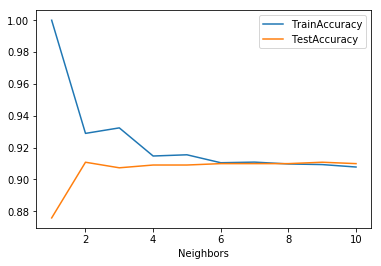

In [12]:
ds_neighbors.set_index("Neighbors", inplace = False).plot()

## - 가중치별 이웃 수 증가에 따른 정확도 변화

In [13]:
max_n_neighbors = 10 
para_n_neighbors = [i+1 for i in range(max_n_neighbors)]*2
# 가중치(uniform, distance_
para_weights = ["uniform"]*max_n_neighbors+["distance"]*max_n_neighbors
# 트레인 및 테스트 정확도 결과 저장용
train_accuracy = []; test_accuracy = [];
# zip(list1,list2,...)를 사용하면 list1과 list2의 인덱스별 값을 하나씩 가져옴
# 1번 loop: n_neighbors = para_n_neighbors[0], weights = para_weights[0]
# 2번 loop: n_neighbors = para_n_neighbors[1], weights = para_weights[1]
for (n_neighbors, weights) in zip(para_n_neighbors, para_weights):
    clf = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights)
    clf.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x,ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x,ds_hmeq_test_y))
# DataFrame 변환
ds_neighbors_weight = pd.DataFrame()
ds_neighbors_weight["Neighbors"] = para_n_neighbors
ds_neighbors_weight["Weights"] = para_weights
ds_neighbors_weight["TrainAccuracy"] = train_accuracy
ds_neighbors_weight["TestAccuracy"] = test_accuracy
ds_neighbors_weight

,Neighbors,Weights,TrainAccuracy,TestAccuracy
0,1,uniform,1.000000,0.875874
1,2,uniform,0.928955,0.910839
2,3,uniform,0.932412,0.907343
3,4,uniform,0.914747,0.909091
4,5,uniform,0.915515,0.909091
5,6,uniform,0.910522,0.909965
6,7,uniform,0.910906,0.909965
7,8,uniform,0.909754,0.909965
8,9,uniform,0.909370,0.910839
9,10,uniform,0.907834,0.909965


In [16]:
# melt method: 데이터를 재구성하는 함수로 id_vars를 기준으로 Transpose
ds_neighbors_weight_melt = pd.melt(ds_neighbors_weight, id_vars=["Neighbors","Weights"])
# variable 열에는 ds_neighbors_weight데이터의 id_vars를 제외한 column 명이 있음
# Weights 값들과 concat하여 새로운 범주 변수명 생성
ds_neighbors_weight_melt["Accuracy"] = ds_neighbors_weight_melt["Weights"] + "_"+ ds_neighbors_weight_melt["variable"]
ds_neighbors_weight_melt

,Neighbors,Weights,variable,value,Accuracy
0,1,uniform,TrainAccuracy,1.000000,uniform_TrainAccuracy
1,2,uniform,TrainAccuracy,0.928955,uniform_TrainAccuracy
2,3,uniform,TrainAccuracy,0.932412,uniform_TrainAccuracy
3,4,uniform,TrainAccuracy,0.914747,uniform_TrainAccuracy
4,5,uniform,TrainAccuracy,0.915515,uniform_TrainAccuracy
5,6,uniform,TrainAccuracy,0.910522,uniform_TrainAccuracy
6,7,uniform,TrainAccuracy,0.910906,uniform_TrainAccuracy
7,8,uniform,TrainAccuracy,0.909754,uniform_TrainAccuracy
8,9,uniform,TrainAccuracy,0.909370,uniform_TrainAccuracy
9,10,uniform,TrainAccuracy,0.907834,uniform_TrainAccuracy


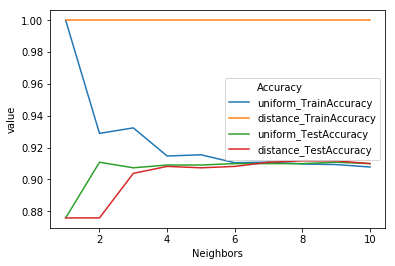

In [17]:
sns.lineplot(x="Neighbors", y="value", hue="Accuracy",data=ds_neighbors_weight_melt)

In [18]:
max_n_neighbors = 10 
para_n_neighbors = [i+1 for i in range(max_n_neighbors)]*3
# 알고리즘(ball_tree, kd_tree, brute)
para_algorithm = ["ball_tree"]*max_n_neighbors+["kd_tree"]*max_n_neighbors+["brute"]*max_n_neighbors
# 트레인 및 테스트 정확도 결과 저장용
train_accuracy = []; test_accuracy = [];
# zip(list1,list2,...)를 사용하면 list1과 list2의 인덱스별 값을 하나씩 가져옴
# 1번 loop: n_neighbors = para_n_neighbors[0], weights = para_weights[0]
# 2번 loop: n_neighbors = para_n_neighbors[1], weights = para_weights[1]
for (n_neighbors, algorithm) in zip(para_n_neighbors, para_algorithm):
    clf = KNeighborsClassifier(n_neighbors = n_neighbors, weights = "uniform", algorithm = algorithm)
    clf.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x,ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x,ds_hmeq_test_y))
# DataFrame 변환
ds_neighbors_algorithm = pd.DataFrame()
ds_neighbors_algorithm["Neighbors"] = para_n_neighbors
ds_neighbors_algorithm["Algorithm"] = para_algorithm
ds_neighbors_algorithm["TrainAccuracy"] = train_accuracy
ds_neighbors_algorithm["TestAccuracy"] = test_accuracy
ds_neighbors_algorithm

,Neighbors,Algorithm,TrainAccuracy,TestAccuracy
0,1,ball_tree,1.000000,0.875874
1,2,ball_tree,0.928955,0.910839
2,3,ball_tree,0.932412,0.907343
3,4,ball_tree,0.914747,0.909091
4,5,ball_tree,0.915515,0.909091
5,6,ball_tree,0.910522,0.909965
6,7,ball_tree,0.910906,0.909965
7,8,ball_tree,0.909754,0.909965
8,9,ball_tree,0.909370,0.910839
9,10,ball_tree,0.907834,0.909965


In [20]:
# melt method: 데이터를 재구성하는 함수로 id_vars를 기준으로 transpose
ds_neighbors_algorithm_melt = pd.melt(ds_neighbors_algorithm, id_vars=["Neighbors","Algorithm"])
# variable 열에는 ds_neighbors_algorithm데이터의 id_vars를 제외한 column 명이 있음
# Algorithm 값들과 concat하여 새로운 범주 변수명 생성
ds_neighbors_algorithm_melt["Accuracy"] = ds_neighbors_algorithm_melt["Algorithm"] + "_"+ ds_neighbors_algorithm_melt["variable"]
ds_neighbors_algorithm_melt

,Neighbors,Algorithm,variable,value,Accuracy
0,1,ball_tree,TrainAccuracy,1.000000,ball_tree_TrainAccuracy
1,2,ball_tree,TrainAccuracy,0.928955,ball_tree_TrainAccuracy
2,3,ball_tree,TrainAccuracy,0.932412,ball_tree_TrainAccuracy
3,4,ball_tree,TrainAccuracy,0.914747,ball_tree_TrainAccuracy
4,5,ball_tree,TrainAccuracy,0.915515,ball_tree_TrainAccuracy
5,6,ball_tree,TrainAccuracy,0.910522,ball_tree_TrainAccuracy
6,7,ball_tree,TrainAccuracy,0.910906,ball_tree_TrainAccuracy
7,8,ball_tree,TrainAccuracy,0.909754,ball_tree_TrainAccuracy
8,9,ball_tree,TrainAccuracy,0.909370,ball_tree_TrainAccuracy
9,10,ball_tree,TrainAccuracy,0.907834,ball_tree_TrainAccuracy


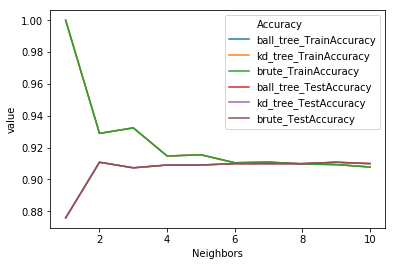

In [21]:
sns.lineplot(x="Neighbors", y="value", hue="Accuracy",data=ds_neighbors_algorithm_melt)

In [22]:
max_n_neighbors = 10 
para_n_neighbors = [i+1 for i in range(max_n_neighbors)]*3
# 거리 계산 방법(minkowski, euclidean, manhattan)
para_metric = ["minkowski"]*max_n_neighbors+["euclidean"]*max_n_neighbors+["manhattan"]*max_n_neighbors
# 트레인 및 테스트 정확도 결과 저장용
train_accuracy = []; test_accuracy = [];

for (n_neighbors, metric) in zip(para_n_neighbors, para_metric):
    clf = KNeighborsClassifier(n_neighbors = n_neighbors, weights = "uniform", algorithm = "ball_tree", metric=metric)
    clf.fit(ds_hmeq_train_x, ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x,ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x,ds_hmeq_test_y))
# DataFrame 변환
ds_neighbors_metric = pd.DataFrame()
ds_neighbors_metric["Neighbors"] = para_n_neighbors
ds_neighbors_metric["Metric"] = para_metric
ds_neighbors_metric["TrainAccuracy"] = train_accuracy
ds_neighbors_metric["TestAccuracy"] = test_accuracy
ds_neighbors_metric

,Neighbors,Metric,TrainAccuracy,TestAccuracy
0,1,minkowski,1.000000,0.875874
1,2,minkowski,0.928955,0.910839
2,3,minkowski,0.932412,0.907343
3,4,minkowski,0.914747,0.909091
4,5,minkowski,0.915515,0.909091
5,6,minkowski,0.910522,0.909965
6,7,minkowski,0.910906,0.909965
7,8,minkowski,0.909754,0.909965
8,9,minkowski,0.909370,0.910839
9,10,minkowski,0.907834,0.909965


In [25]:
# melt method: 데이터를 재구성하는 함수로 id_vars를 기준으로 transpose
ds_neighbors_metric_melt = pd.melt(ds_neighbors_metric, id_vars=["Neighbors","Metric"])
# variable 열에는 ds_neighbors_algorithm데이터의 id_vars를 제외한 column 명이 있음
# Algorithm 값들과 concat하여 새로운 범주 변수명 생성
ds_neighbors_metric_melt["Accuracy"] = ds_neighbors_metric_melt["Metric"] + "_"+ ds_neighbors_metric_melt["variable"]
ds_neighbors_metric_melt

,Neighbors,Metric,variable,value,Accuracy
0,1,minkowski,TrainAccuracy,1.000000,minkowski_TrainAccuracy
1,2,minkowski,TrainAccuracy,0.928955,minkowski_TrainAccuracy
2,3,minkowski,TrainAccuracy,0.932412,minkowski_TrainAccuracy
3,4,minkowski,TrainAccuracy,0.914747,minkowski_TrainAccuracy
4,5,minkowski,TrainAccuracy,0.915515,minkowski_TrainAccuracy
5,6,minkowski,TrainAccuracy,0.910522,minkowski_TrainAccuracy
6,7,minkowski,TrainAccuracy,0.910906,minkowski_TrainAccuracy
7,8,minkowski,TrainAccuracy,0.909754,minkowski_TrainAccuracy
8,9,minkowski,TrainAccuracy,0.909370,minkowski_TrainAccuracy
9,10,minkowski,TrainAccuracy,0.907834,minkowski_TrainAccuracy


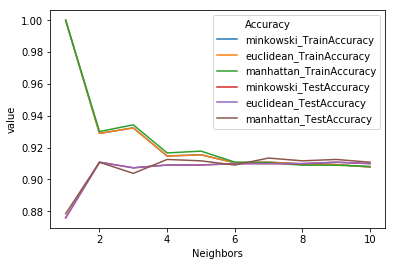

In [26]:
sns.lineplot(x="Neighbors", y="value", hue="Accuracy",data=ds_neighbors_metric_melt)

In [38]:
clf_model = KNeighborsClassifier(n_neighbors=4, weights = "uniform", algorithm = "ball_tree", metric = "euclidean")
clf_model.fit(ds_hmeq_train_x,ds_hmeq_train_y)
# 훈련 데이터 셋 정확도
print("train data accuracy: {0:.3f}".format(clf_model.score(ds_hmeq_train_x,ds_hmeq_train_y)))
# 테스트 데이터 셋 정확도
print("test data accuracy: {0:.3f}".format(clf_model.score(ds_hmeq_test_x,ds_hmeq_test_y)))

test data accuracy: 0.915
test data accuracy: 0.909


# KNN(K-Nearest Neighbors)_실습